# Tinder para empresas

## Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
from scipy.spatial import distance
from random import choice, shuffle
from beautifultable import BeautifulTable

## Preprocesado csv de las encuestas UX/UI


Descargar como CSV cada uno de los archivos de las respuestas en la carpeta ```./encuestas``` con el nombre por defecto que proporciona google: 
```
Student Form: 
https://docs.google.com/forms/d/17uP0aTeXo7gHRau3W5--CA4-vYjA1ur5eX2L8D25_xk/edit?ts=5cb08207

Company Form: 
https://docs.google.com/forms/d/1JpKsGgOfVaLiKg0uXTLb-Xp8TjG6k4KRz07pFd_GHuE/edit?ts=5cb07555

```

## Actual Madrid UX/UI
```

```

### 1. Companies

In [2]:
# Funciones translate CSV

DIC_COMPANIES = {
    "What is the name of your company?": "name", 
    'Does your company have specific language requirements for this position? [English]': 'english', 
    'What is your level in the following languages? [Spanish]': 'spanish', # está mal en el excel el texto
    'What is your level in the following languages? [Portuguese]': 'portuguese', 
    'What is your level in the following languages? [French]': 'french', 
    'What is your level in the following languages? [Dutch]': 'dutch', 
    'What is your level in the following languages? [Catalan]': 'catalan', 
    'Where will this position be located?': 'location', 
    'Regarding remote working, how many days a week could the employee work off site?': 'offsite', 
    'On a scale from 1 to 10, how much time will the employee be spending working on back end and front end?': 'position', 
    
    # problema gordo, hay que hacer dummies ya que los excel no son similares
    "Mark the top 3 competencies you are looking for in an employee for this position [User research]": "user", 
    "Mark the top 3 competencies you are looking for in an employee for this position [Methodologies: Desing thinking, Google Sprint,...]": "methodologies", 
    "Mark the top 3 competencies you are looking for in an employee for this positione [Usability Testing]": "usability", 
    "Mark the top 3 competencies you are looking for in an employee for this position [Information Architecture ]": "information", 
    "Mark the top 3 competencies you are looking for in an employee for this position [Interaction Design ]": "interaction", 
    "Mark the top 3 competencies you are looking for in an employee for this position [Visual Design ]": "visual", 
    "Mark the top 3 competencies you are looking for in an employee for this position [HTML & CSS Basic Understanding]": "html", 
    "Mark the top 3 competencies you think you have [Motion design]": "motion", 
    
    
    
    'From this list, please rank these 3 soft skills in order of importance for this position [Motivation and ability to overcome problems: employee has a passionate, can-do attitude and proactively looks for solutions to every problem they encounter]': 'motivation',
    'From this list, please rank these 3 soft skills in order of importance for this position [Coachability: Employee is receptive and actively listens and acts on feedback received]': 'coachability',
    'From this list, please rank these 3 soft skills in order of importance for this position [Teamwork: Employee is able to receive and provide value in a team environment]\r': 'teamwork' # El \r del final es para que sirva de terminador
    }




LANGUAGES = ['english', 'spanish', 'portuguese', 'french', 'dutch', 'catalan']

# hardskills en función de UXUI
HARDSKILLS = ['user', 'methodologies', 'usability', 'information', 'interaction', 'visual', 
              'html', 'motion']


def translate_language(x): 
    DIC_RESP_LANGUAGE = {
        # Company
        "No need": 1, 
        "Must be able to read basic documentation": 2, 
        "Must be able to read documentation and have an informal conversation": 3, 
        "Must be able to read documentation and communicate in a meeting": 4, 
        "Can work in full capacity in this language": 5, 
        # Students same
        "No Experience": 1, 
        "I'm able to read basic documentation": 2, 
        "I'm able to read documentation and have an informal conversation": 3, 
        "Able to read documentation and communicate in a meeting": 4, 
        "Can work in full capacity in this language": 5
    }
    # return 0 if x not in DIC_RESP_LANGUAGE.keys() else DIC_RESP_LANGUAGE[x] 
    return DIC_RESP_LANGUAGE.get(x, 0) # 0 default

def translate_location(x): 
    DIC_RESP_LOCATION = {
        # Company
        "In the city where the campus is located": 1, 
        "In the country where the campus is located": 2, 
        "In a city in another country": 3, 
        # Student
        "In the city where the campus is located": 1, 
        "Anywhere in the country where the campus is located": 2, 
        "Anywhere in the world": 3
    }
    # return 0 if x not in DIC_RESP_LOCATION.keys() else DIC_RESP_LOCATION[x] 
    return DIC_RESP_LOCATION.get(x, 0) # 0 default


def translate_offsite(x): 
    DIC_RESP_OFFSITE = {
        # Company
        "100% office-based job. We're not keen on remote working.": 1, 
        "1-2 Days a week": 2, 
        "3+ Days. It's up to the employee": 3, 
        "100% remote-based job. No physical office.": 4, 
        # Student
        "100% office-based job.": 1, 
        "1-2 Days a week": 2, 
        "3+ Days": 3, 
        "100% remote-based job. No physical office.": 4
    }
    # return 0 if x not in DIC_RESP_OFFSITE.keys() else DIC_RESP_OFFSITE[x] 
    return DIC_RESP_OFFSITE.get(x, 0) # 0 default

def translate_position(x): 
    try: 
        return int(x)
    except: 
        return 0 # default

def translate_hardskills(x): 
    DIC_RESP_HARDSKILLS = {
        # Company
        "No Need": 1, 
        "Nice to have: They should have a basic knowledge": 2, 
        "Must have: Must be able to work with the technology on a regular basis": 3,   
        # Student
        "No Experience": 1, 
        "Basic Knowledge: I've played around with it": 2, 
        "Advanced Knowledge: I'm comfortable working with it": 3
    }
    # return 0 if x not in DIC_RESP_HARDSKILLS.keys() else DIC_RESP_HARDSKILLS[x] 
    return DIC_RESP_HARDSKILLS.get(x, 0) # 0 default

   

def translate_csv(path, dic): 
    # open and setup columns
    # df = pd.read_csv(path, sep=',', index_col=0, lineterminator='\n') # para cuando esta timestamp
    df = pd.read_csv(path, sep=',', lineterminator='\n')
    display(df.head())
    df.rename(index=str, columns=dic, inplace=True)
    print(df.columns)
    df.index = df.name
    
    df.drop(columns=['name'], axis=1, inplace=True)
    display(df.head())
    
    print(df.columns)
    
    # languages
    for language in LANGUAGES: 
        df[language] = df[language].apply(translate_language)
    
    # location
    df['location'] = df['location'].apply(translate_location)    
    
    # offsite
    df['offsite'] = df['offsite'].apply(translate_offsite)
    
    # position
    df['position'] = df['position'].apply(translate_position)
    
    # hardskills
    for hardskill in HARDSKILLS: 
        df[hardskill] = df[hardskill].apply(translate_hardskills)
    
    return df

In [3]:
# COMPANIES_ENCUESTAS_CSV = './encuestas/Web - Ironhack Matchmaking Company Form (Responses) - Form Responses 1.csv'

# BNC web-day1
# COMPANIES_ENCUESTAS_CSV = './encuestas/Web - Ironhack Matchmaking Company Form (Responses) - 11APRWEB.csv'

# BNC web-day2
COMPANIES_ENCUESTAS_CSV = './encuestas/HIRING FAIR APR 2019 MATCHMAKING - albertogcmr - UX COMPANIES .csv'

companies_enc = translate_csv(path=COMPANIES_ENCUESTAS_CSV, dic=DIC_COMPANIES)
display(companies_enc.head(5))
# display(companies_enc.dtypes)
COMPANIES_CLEAN_CSV = './encuestas/companies.csv'
companies_enc.to_csv(COMPANIES_CLEAN_CSV, index=True)

# companies_enc.columns

,What is the name of your company?,Does your company have specific language requirements for this position? [English],What is your level in the following languages? [Spanish],What is your level in the following languages? [Portuguese],What is your level in the following languages? [French],What is your level in the following languages? [Dutch],What is your level in the following languages? [Catalan],Where will this position be located?,"Regarding remote working, how many days a week could the employee work off site?","On a scale from 1 to 10, how much time will the employee be spending working on back end and front end?",...,"Mark the top 3 competencies you are looking for in an employee for this position [Methodologies: Desing thinking, Google Sprint,...]",Mark the top 3 competencies you are looking for in an employee for this positione [Usability Testing],Mark the top 3 competencies you are looking for in an employee for this position [Information Architecture ],Mark the top 3 competencies you are looking for in an employee for this position [Interaction Design ],Mark the top 3 competencies you are looking for in an employee for this position [Visual Design ],Mark the top 3 competencies you are looking for in an employee for this position [HTML & CSS Basic Understanding],Mark the top 3 competencies you think you have [Motion design],"From this list, please rank these 3 soft skills in order of importance for this position [Motivation and ability to overcome problems: employee has a passionate, can-do attitude and proactively looks for solutions to every problem they encounter]","From this list, please rank these 3 soft skills in order of importance for this position [Coachability: Employee is receptive and actively listens and acts on feedback received]","From this list, please rank these 3 soft skills in order of importance for this position [Teamwork: Employee is able to receive and provide value in a team environment]"
0,Sopra Steria,Must be able to read basic documentation,Can work in full capacity in this language,NaN,NaN,NaN,NaN,In the city where the campus is located,1-2 Days a week,5,...,NaN,NaN,NaN,Must have: Must be able to work with the techn...,Must have: Must be able to work with the techn...,NaN,NaN,3,2,1
1,vt-lab,"Must be able to read basic documentation, Must...",Can work in full capacity in this language,NaN,NaN,NaN,NaN,In the city where the campus is located,1-2 Days a week,5,...,NaN,Must have: Must be able to work with the techn...,NaN,NaN,Must have: Must be able to work with the techn...,NaN,NaN,1,3,2
2,Barrabes,"Must be able to read basic documentation, Must...",Can work in full capacity in this language,NaN,NaN,NaN,NaN,In the city where the campus is located,1-2 Days a week,5,...,NaN,Must have: Must be able to work with the techn...,NaN,Must have: Must be able to work with the techn...,Must have: Must be able to work with the techn...,NaN,NaN,1,3,2
3,Sentisis,"Must be able to read basic documentation, Must...",Can work in full capacity in this language,NaN,NaN,NaN,NaN,In the city where the campus is located,1-2 Days a week,4,...,NaN,Must have: Must be able to work with the techn...,NaN,Must have: Must be able to work with the techn...,NaN,NaN,NaN,2,3,1
4,Habitant,Must be able to read documentation and communi...,Can work in full capacity in this language,NaN,NaN,NaN,NaN,In the city where the campus is located,1-2 Days a week,4,...,NaN,NaN,Must have: Must be able to work with the techn...,Must have: Must be able to work with the techn...,Must have: Must be able to work with the techn...,NaN,NaN,1,3,2


Index(['name', 'english', 'spanish', 'portuguese', 'french', 'dutch',
       'catalan', 'location', 'offsite', 'position', 'user', 'methodologies',
       'usability', 'information', 'interaction', 'visual', 'html', 'motion',
       'motivation', 'coachability', 'teamwork'],
      dtype='object')


,english,spanish,portuguese,french,dutch,catalan,location,offsite,position,user,methodologies,usability,information,interaction,visual,html,motion,motivation,coachability,teamwork
name,,,,,,,,,,,,,,,,,,,,
Sopra Steria,Must be able to read basic documentation,Can work in full capacity in this language,NaN,NaN,NaN,NaN,In the city where the campus is located,1-2 Days a week,5,Must have: Must be able to work with the techn...,NaN,NaN,NaN,Must have: Must be able to work with the techn...,Must have: Must be able to work with the techn...,NaN,NaN,3,2,1
vt-lab,"Must be able to read basic documentation, Must...",Can work in full capacity in this language,NaN,NaN,NaN,NaN,In the city where the campus is located,1-2 Days a week,5,Must have: Must be able to work with the techn...,NaN,Must have: Must be able to work with the techn...,NaN,NaN,Must have: Must be able to work with the techn...,NaN,NaN,1,3,2
Barrabes,"Must be able to read basic documentation, Must...",Can work in full capacity in this language,NaN,NaN,NaN,NaN,In the city where the campus is located,1-2 Days a week,5,NaN,NaN,Must have: Must be able to work with the techn...,NaN,Must have: Must be able to work with the techn...,Must have: Must be able to work with the techn...,NaN,NaN,1,3,2
Sentisis,"Must be able to read basic documentation, Must...",Can work in full capacity in this language,NaN,NaN,NaN,NaN,In the city where the campus is located,1-2 Days a week,4,Must have: Must be able to work with the techn...,NaN,Must have: Must be able to work with the techn...,NaN,Must have: Must be able to work with the techn...,NaN,NaN,NaN,2,3,1
Habitant,Must be able to read documentation and communi...,Can work in full capacity in this language,NaN,NaN,NaN,NaN,In the city where the campus is located,1-2 Days a week,4,NaN,NaN,NaN,Must have: Must be able to work with the techn...,Must have: Must be able to work with the techn...,Must have: Must be able to work with the techn...,NaN,NaN,1,3,2


Index(['english', 'spanish', 'portuguese', 'french', 'dutch', 'catalan',
       'location', 'offsite', 'position', 'user', 'methodologies', 'usability',
       'information', 'interaction', 'visual', 'html', 'motion', 'motivation',
       'coachability', 'teamwork'],
      dtype='object')


,english,spanish,portuguese,french,dutch,catalan,location,offsite,position,user,methodologies,usability,information,interaction,visual,html,motion,motivation,coachability,teamwork
name,,,,,,,,,,,,,,,,,,,,
Sopra Steria,2,5,0,0,0,0,1,2,5,3,0,0,0,3,3,0,0,3,2,1
vt-lab,0,5,0,0,0,0,1,2,5,3,0,3,0,0,3,0,0,1,3,2
Barrabes,0,5,0,0,0,0,1,2,5,0,0,3,0,3,3,0,0,1,3,2
Sentisis,0,5,0,0,0,0,1,2,4,3,0,3,0,3,0,0,0,2,3,1
Habitant,4,5,0,0,0,0,1,2,4,0,0,0,3,3,3,0,0,1,3,2


In [4]:
# list(companies_enc.loc['Company ALL MAX']), list(companies_enc.loc['Company ALL MIN'])

In [5]:
# STUDENTS_ENCUESTAS_CSV = './encuestas/Web - Ironhack Matchmaking Student Form (Responses) - Form Responses 1.csv'
# BNC web students day1
# STUDENTS_ENCUESTAS_CSV = './encuestas/BCN - Web Abril - Ironhack Matchmaking Student Form (Responses) - 11APR.csv'

# BNC web students day2
# STUDENTS_ENCUESTAS_CSV = './encuestas/BCN - Web Abril - Ironhack Matchmaking Student Form (Responses) - Form Responses 1.csv'

# Madrid UXUI Students
STUDENTS_ENCUESTAS_CSV = './encuestas/HIRING FAIR APR 2019 MATCHMAKING - STUDENTS UX HF APR 2019.csv'

DIC_STUDENTS = {
    "NOMBRE Y APELLIDOS": "name",  # \n porque el la última columna
    "What is your level in the following languages? [English]": 'english', 
    "What is your level in the following languages? [Spanish]": 'spanish', 
    'What is your level in the following languages? [Portuguese]': 'portuguese', 
    'What is your level in the following languages? [French]': 'french', 
    'What is your level in the following languages? [Dutch]': 'dutch', 
    'What is your level in the following languages? [Catalan]': 'catalan', 
    "What are your preferences for job location?": 'location', 
    "What kind of roles are you open to in terms of remote working?": 'offsite', 
    "In you role, how would you prefer to allocate your time between working on UX and working on UI?": 'position', 
    'Mark the top 3 competencies you think you have  [User research]': 'user', # doble espacio entre have y [ por que sí..
    'Mark the top 3 competencies you think you have  [Methodologies: Desing thinking, Google Sprint,...]': 'methodologies', 
    'Mark the top 3 competencies you think you have  [Usability Testing]': 'usability', 
    'Mark the top 3 competencies you think you have  [Information Architecture ]': 'information', 
    'Mark the top 3 competencies you think you have  [Interaction Design ]': 'interaction', 
    'Mark the top 3 competencies you think you have  [Visual Design ]': 'visual', 
    'Mark the top 3 competencies you think you have  [HTML & CSS Basic Understanding]': 'html', 
    'Mark the top 3 competencies you think you have  [Motion design]': 'motion', 
    "From this list of soft skills, please rank in order the ones you consider you're stronger at [Motivation and ability to overcome problems: I am passionate, have a can-do attitude and proactively look for solutions to every problem.]": 'motivation',
    "From this list of soft skills, please rank in order the ones you consider you're stronger at [Coachability: I am receptive and actively listen and act on the feedback I receive]": 'coachability',
    "From this list of soft skills, please rank in order the ones you consider you're stronger at [Teamwork: I'm able to receive and provide value in a team environment]\r": 'teamwork' # El \r del final es para que sirva de terminador
    }

students_enc = translate_csv(path=STUDENTS_ENCUESTAS_CSV, dic=DIC_STUDENTS)

,NOMBRE Y APELLIDOS,What is your level in the following languages? [English],What is your level in the following languages? [Spanish],What is your level in the following languages? [Portuguese],What is your level in the following languages? [French],What is your level in the following languages? [Dutch],What is your level in the following languages? [Catalan],What are your preferences for job location?,What kind of roles are you open to in terms of remote working?,"In you role, how would you prefer to allocate your time between working on UX and working on UI?",...,"Mark the top 3 competencies you think you have [Methodologies: Desing thinking, Google Sprint,...]",Mark the top 3 competencies you think you have [Usability Testing],Mark the top 3 competencies you think you have [Information Architecture ],Mark the top 3 competencies you think you have [Interaction Design ],Mark the top 3 competencies you think you have [Visual Design ],Mark the top 3 competencies you think you have [HTML & CSS Basic Understanding],Mark the top 3 competencies you think you have [Motion design],"From this list of soft skills, please rank in order the ones you consider you're stronger at [Motivation and ability to overcome problems: I am passionate, have a can-do attitude and proactively look for solutions to every problem.]","From this list of soft skills, please rank in order the ones you consider you're stronger at [Coachability: I am receptive and actively listen and act on the feedback I receive]","From this list of soft skills, please rank in order the ones you consider you're stronger at [Teamwork: I'm able to receive and provide value in a team environment]"
0,Cristina Alonso Amiñoso,I'm able to read documentation and have an inf...,Can work in full capacity in this language,NaN,NaN,NaN,NaN,"In the city where the campus is located, In th...","100% office-based job., 100% remote-based job....",5.0,...,Advanced Knowledge: I'm comfortable working wi...,Advanced Knowledge: I'm comfortable working wi...,Advanced Knowledge: I'm comfortable working wi...,Advanced Knowledge: I'm comfortable working wi...,Advanced Knowledge: I'm comfortable working wi...,Basic Knowledge: I've played around with it,Basic Knowledge: I've played around with it,1,3,2
1,Marleny Francisco,Able to read documentation and communicate in ...,Can work in full capacity in this language,NaN,NaN,NaN,NaN,In the city where the campus is located,"100% office-based job., 1-2 Days a week, 3+ Days",7.0,...,Advanced Knowledge: I'm comfortable working wi...,NaN,Advanced Knowledge: I'm comfortable working wi...,NaN,Advanced Knowledge: I'm comfortable working wi...,NaN,NaN,3,1,2
2,Carmen Bustillos,Able to read documentation and communicate in ...,Can work in full capacity in this language,NaN,NaN,NaN,NaN,"In the city where the campus is located, In th...","100% office-based job., 1-2 Days a week",6.0,...,Advanced Knowledge: I'm comfortable working wi...,Basic Knowledge: I've played around with it,NaN,NaN,Advanced Knowledge: I'm comfortable working wi...,NaN,NaN,3,1,2
3,Karla Imbert Lamiquiz,Can work in full capacity in this language,Can work in full capacity in this language,NaN,I'm able to read basic documentation,NaN,NaN,In the city where the campus is located,"100% office-based job., 1-2 Days a week, 3+ Days",4.0,...,Advanced Knowledge: I'm comfortable working wi...,NaN,NaN,NaN,Advanced Knowledge: I'm comfortable working wi...,NaN,NaN,1,3,2
4,Carlota Sánchez-Robles Herrero,Can work in full capacity in this language,Can work in full capacity in this language,NaN,I'm able to read documentation and have an inf...,NaN,NaN,"In the city where the campus is located, In th...","1-2 Days a week, 3+ Days",3.0,...,Advanced Knowledge: I'm comfortable working wi...,NaN,Advanced Knowledge: I'm comfortable working wi...,NaN,NaN,NaN,NaN,3,2,1


Index(['name', 'english', 'spanish', 'portuguese', 'french', 'dutch',
       'catalan', 'location', 'offsite', 'position', 'user', 'methodologies',
       'usability', 'information', 'interaction', 'visual', 'html', 'motion',
       'motivation', 'coachability', 'teamwork'],
      dtype='object')


,english,spanish,portuguese,french,dutch,catalan,location,offsite,position,user,methodologies,usability,information,interaction,visual,html,motion,motivation,coachability,teamwork
name,,,,,,,,,,,,,,,,,,,,
Cristina Alonso Amiñoso,I'm able to read documentation and have an inf...,Can work in full capacity in this language,NaN,NaN,NaN,NaN,"In the city where the campus is located, In th...","100% office-based job., 100% remote-based job....",5.0,Advanced Knowledge: I'm comfortable working wi...,Advanced Knowledge: I'm comfortable working wi...,Advanced Knowledge: I'm comfortable working wi...,Advanced Knowledge: I'm comfortable working wi...,Advanced Knowledge: I'm comfortable working wi...,Advanced Knowledge: I'm comfortable working wi...,Basic Knowledge: I've played around with it,Basic Knowledge: I've played around with it,1,3,2
Marleny Francisco,Able to read documentation and communicate in ...,Can work in full capacity in this language,NaN,NaN,NaN,NaN,In the city where the campus is located,"100% office-based job., 1-2 Days a week, 3+ Days",7.0,NaN,Advanced Knowledge: I'm comfortable working wi...,NaN,Advanced Knowledge: I'm comfortable working wi...,NaN,Advanced Knowledge: I'm comfortable working wi...,NaN,NaN,3,1,2
Carmen Bustillos,Able to read documentation and communicate in ...,Can work in full capacity in this language,NaN,NaN,NaN,NaN,"In the city where the campus is located, In th...","100% office-based job., 1-2 Days a week",6.0,Advanced Knowledge: I'm comfortable working wi...,Advanced Knowledge: I'm comfortable working wi...,Basic Knowledge: I've played around with it,NaN,NaN,Advanced Knowledge: I'm comfortable working wi...,NaN,NaN,3,1,2
Karla Imbert Lamiquiz,Can work in full capacity in this language,Can work in full capacity in this language,NaN,I'm able to read basic documentation,NaN,NaN,In the city where the campus is located,"100% office-based job., 1-2 Days a week, 3+ Days",4.0,Advanced Knowledge: I'm comfortable working wi...,Advanced Knowledge: I'm comfortable working wi...,NaN,NaN,NaN,Advanced Knowledge: I'm comfortable working wi...,NaN,NaN,1,3,2
Carlota Sánchez-Robles Herrero,Can work in full capacity in this language,Can work in full capacity in this language,NaN,I'm able to read documentation and have an inf...,NaN,NaN,"In the city where the campus is located, In th...","1-2 Days a week, 3+ Days",3.0,Advanced Knowledge: I'm comfortable working wi...,Advanced Knowledge: I'm comfortable working wi...,NaN,Advanced Knowledge: I'm comfortable working wi...,NaN,NaN,NaN,NaN,3,2,1


Index(['english', 'spanish', 'portuguese', 'french', 'dutch', 'catalan',
       'location', 'offsite', 'position', 'user', 'methodologies', 'usability',
       'information', 'interaction', 'visual', 'html', 'motion', 'motivation',
       'coachability', 'teamwork'],
      dtype='object')


In [6]:
# students_enc.drop(columns=['todrop'], axis=1, inplace=True)
display(students_enc.head(5))
# display(students_enc.dtypes)
STUDENTS_CLEAN_CSV = './encuestas/students.csv'
students_enc.to_csv(STUDENTS_CLEAN_CSV, index=True)

# students_enc.columns

,english,spanish,portuguese,french,dutch,catalan,location,offsite,position,user,methodologies,usability,information,interaction,visual,html,motion,motivation,coachability,teamwork
name,,,,,,,,,,,,,,,,,,,,
Cristina Alonso Amiñoso,3,5,0,0,0,0,0,0,5,3,3,3,3,3,3,2,2,1,3,2
Marleny Francisco,4,5,0,0,0,0,1,0,7,0,3,0,3,0,3,0,0,3,1,2
Carmen Bustillos,4,5,0,0,0,0,0,0,6,3,3,2,0,0,3,0,0,3,1,2
Karla Imbert Lamiquiz,5,5,0,2,0,0,1,0,4,3,3,0,0,0,3,0,0,1,3,2
Carlota Sánchez-Robles Herrero,5,5,0,3,0,0,0,0,3,3,3,0,3,0,0,0,0,3,2,1


In [7]:
# list(students_enc.loc['Student ALL MAX']), list(students_enc.loc['Student ALL MIN'])

In [8]:
# Testing
companies_enc.columns == students_enc.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [9]:
companies_enc.shape, students_enc.shape

((16, 20), (44, 20))

## Tratado de los CSVs

In [10]:
# Alumnos

STUDENTS_CSV = STUDENTS_CLEAN_CSV # antes -> './input/students.csv'
COMPANIES_CSV = COMPANIES_CLEAN_CSV # antes -> './input/companies.csv'

def csv2dataframe(path): 
    return pd.read_csv(path, sep=',', index_col=0, lineterminator='\n')

def adquisition(): 
    students = csv2dataframe(STUDENTS_CSV)
    companies = csv2dataframe(COMPANIES_CSV)
    return students, companies

students, companies = adquisition()

display(len(students.columns))

20

In [11]:
# normalizacion. Por columnas en alumnos o empresas hay un 0.0 y un 1.0

def normalize_2dfs(students, companies): 
    
    # min(s, c, 0) -> para que no de NaN
    # mins = [min(s, c, 0) for s, c in zip(students.min(), companies.min())]
    mins = [min(s, c) for s, c in zip(students.min(), companies.min())]
    students = students-mins
    companies = companies-mins
    
    # maxs = [max(s, c, 1) for s, c in zip(students.max(), companies.max())]
    maxs = [max(s, c) for s, c in zip(students.max(), companies.max())]
    students = students/maxs
    companies = companies/maxs
    
    return students, companies

students_norm, companies_norm = normalize_2dfs(students, companies)

display(students), display(companies)
display(students_norm), display(companies_norm)

,english,spanish,portuguese,french,dutch,catalan,location,offsite,position,user,methodologies,usability,information,interaction,visual,html,motion,motivation,coachability,teamwork
name,,,,,,,,,,,,,,,,,,,,
Cristina Alonso Amiñoso,3,5,0,0,0,0,0,0,5,3,3,3,3,3,3,2,2,1,3,2
Marleny Francisco,4,5,0,0,0,0,1,0,7,0,3,0,3,0,3,0,0,3,1,2
Carmen Bustillos,4,5,0,0,0,0,0,0,6,3,3,2,0,0,3,0,0,3,1,2
Karla Imbert Lamiquiz,5,5,0,2,0,0,1,0,4,3,3,0,0,0,3,0,0,1,3,2
Carlota Sánchez-Robles Herrero,5,5,0,3,0,0,0,0,3,3,3,0,3,0,0,0,0,3,2,1
Maruxa Moreira Pérez,3,5,2,0,0,0,1,0,8,3,3,3,2,3,3,2,2,1,3,2
Barbara Lopez Mauriello,5,5,0,0,0,0,0,0,5,0,2,2,3,3,3,2,2,3,2,1
Víctor Andrés Hernández,2,5,0,0,0,0,1,2,8,2,3,3,2,3,3,2,2,2,3,1
Luis Camacho Cabo,5,5,2,0,0,0,0,0,4,3,2,2,2,3,3,0,0,2,3,1


,english,spanish,portuguese,french,dutch,catalan,location,offsite,position,user,methodologies,usability,information,interaction,visual,html,motion,motivation,coachability,teamwork
name,,,,,,,,,,,,,,,,,,,,
Sopra Steria,2,5,0,0,0,0,1,2,5,3,0,0,0,3,3,0,0,3,2,1
vt-lab,0,5,0,0,0,0,1,2,5,3,0,3,0,0,3,0,0,1,3,2
Barrabes,0,5,0,0,0,0,1,2,5,0,0,3,0,3,3,0,0,1,3,2
Sentisis,0,5,0,0,0,0,1,2,4,3,0,3,0,3,0,0,0,2,3,1
Habitant,4,5,0,0,0,0,1,2,4,0,0,0,3,3,3,0,0,1,3,2
Minsait,4,5,0,0,0,0,1,2,7,0,0,0,0,0,3,3,3,1,3,2
Syntonize,0,5,0,0,0,0,1,1,5,0,3,3,3,0,0,0,0,3,2,1
UXSmobile,4,5,0,0,0,0,1,2,2,3,3,3,3,0,0,0,0,3,2,1
Bravent,5,5,0,0,0,0,1,2,5,0,3,0,0,0,0,0,0,1,2,3


,english,spanish,portuguese,french,dutch,catalan,location,offsite,position,user,methodologies,usability,information,interaction,visual,html,motion,motivation,coachability,teamwork
name,,,,,,,,,,,,,,,,,,,,
Cristina Alonso Amiñoso,0.6,1.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.555556,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,0.666667,0.0,1.0,0.5
Marleny Francisco,0.8,1.0,0.000000,0.0,0.0,0.0,0.333333,0.00,0.777778,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,0.0,0.5
Carmen Bustillos,0.8,1.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.666667,1.000000,1.000000,0.666667,0.000000,0.000000,1.000000,0.000000,0.000000,1.0,0.0,0.5
Karla Imbert Lamiquiz,1.0,1.0,0.000000,0.4,0.0,0.0,0.333333,0.00,0.444444,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.0,0.5
Carlota Sánchez-Robles Herrero,1.0,1.0,0.000000,0.6,0.0,0.0,0.000000,0.00,0.333333,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.5,0.0
Maruxa Moreira Pérez,0.6,1.0,0.666667,0.0,0.0,0.0,0.333333,0.00,0.888889,1.000000,1.000000,1.000000,0.666667,1.000000,1.000000,0.666667,0.666667,0.0,1.0,0.5
Barbara Lopez Mauriello,1.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.555556,0.000000,0.666667,0.666667,1.000000,1.000000,1.000000,0.666667,0.666667,1.0,0.5,0.0
Víctor Andrés Hernández,0.4,1.0,0.000000,0.0,0.0,0.0,0.333333,0.50,0.888889,0.666667,1.000000,1.000000,0.666667,1.000000,1.000000,0.666667,0.666667,0.5,1.0,0.0
Luis Camacho Cabo,1.0,1.0,0.666667,0.0,0.0,0.0,0.000000,0.00,0.444444,1.000000,0.666667,0.666667,0.666667,1.000000,1.000000,0.000000,0.000000,0.5,1.0,0.0


,english,spanish,portuguese,french,dutch,catalan,location,offsite,position,user,methodologies,usability,information,interaction,visual,html,motion,motivation,coachability,teamwork
name,,,,,,,,,,,,,,,,,,,,
Sopra Steria,0.4,1.0,0.0,0.0,0.0,0.0,0.333333,0.50,0.555556,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.5,0.0
vt-lab,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.50,0.555556,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.5
Barrabes,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.50,0.555556,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.5
Sentisis,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.50,0.444444,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.5,1.0,0.0
Habitant,0.8,1.0,0.0,0.0,0.0,0.0,0.333333,0.50,0.444444,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.5
Minsait,0.8,1.0,0.0,0.0,0.0,0.0,0.333333,0.50,0.777778,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.5
Syntonize,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.25,0.555556,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0
UXSmobile,0.8,1.0,0.0,0.0,0.0,0.0,0.333333,0.50,0.222222,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0
Bravent,1.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.50,0.555556,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0


(None, None)

In [12]:
students_norm.columns

Index(['english', 'spanish', 'portuguese', 'french', 'dutch', 'catalan',
       'location', 'offsite', 'position', 'user', 'methodologies', 'usability',
       'information', 'interaction', 'visual', 'html', 'motion', 'motivation',
       'coachability', 'teamwork'],
      dtype='object')

In [13]:
# Matching

# PESOS = (alumnos.columns)

'''
P = [2,1,1,1,3,1,1,1,1,5, 1, 1, 1, 1, 1, 1, 1 ,1, 1, 1, 1, 1 ,1, 1, 1]
W = {col: p for col, p in zip(students_norm.columns, P)}
'''

# ['english', 'spanish', 'portuguese', 'french', 'dutch', 'catalan','location', 'offsite', 
# 'position', 'user', 'methodologies', 'usability','information', 'interaction', 'visual', 
# 'html', 'motion', 'motivation','coachability', 'teamwork']

PESOS = {
    'english': 1,
    'spanish': 1,
    'portuguese': 1,
    'french': 1,
    'dutch': 1,
    'catalan': 1,
    'location': 1, 
    'offsite': 1,
    'position': 5, # importante
    'user': 5,     # importante las técnicas
    'methodologies': 5,
    'usability': 5,
    'information': 5,
    'interaction': 5,
    'visual': 5,
    'html': 5,
    'motion': 5,
    'motivation': 1,
    'coachability': 1,
    'teamwork': 1
}

def calc_dist(s_array, c_array, weights_val): 
    ''' 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html
    
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
    scipy.spatial.distance.cosine
    '''
    return calc_match(distance.euclidean(s_array, c_array, weights_val))

def calc_match(distance): 
    ''' [0, 1] -> [1, 0]'''
    return 1/(1+distance)
'''
def match(student, company, weights=W): 
    return calc_dist(student, company, list(weights.values()))
'''
def match(student, company, weights=PESOS): 
    student = [min(s, c) for s, c in zip(student, company)] # añadimos para que la sobrecualificación de un estudiante no empeore el matchin
    return calc_dist(student, company, list(weights.values()))

In [14]:
# match(students_norm.loc['alumno1'], companies_norm.loc['empresa1'])


# Emparejamiento

En cada ronda se crea una pareja alumno-empresa empezando por el mejor %. Luego se pasa al siguente alumno. Si la empresa que hacía mejor match es la del caso anterior, pasa a su segundo mejor match, etc. 

En cada ronda se cambia el estudiante que elige primero, entre los que no han ido primeros

In [15]:
# !jupyter kernelspec list
# import sys
# sys.path

In [16]:
# create dataframe de tamañ0 SxC

matching = pd.DataFrame(np.zeros((len(students), len(companies))) , columns=companies.index, index=students.index)
# matching.head()

In [17]:
# matching.index, matching.columns

In [18]:
# display(students_norm.head()), display(companies_norm.head())

In [19]:
# matching.loc['alumno1', 'empresa3']

def calculate_match(matching, df1, df2): 
    # matching = pd.DataFrame(np.zeros((len(students), len(companies))) , columns=companies.index, index=students.index)
    for a in matching.index: 
        for c in matching.columns:
            matching.loc[a, c] = match(df1.loc[a], df2.loc[c], weights=PESOS)
    return matching

matching = calculate_match(matching, students_norm, companies_norm)

# matching es una matriz de elementos entre [0, 1]
# matching.min().min(), matching.max().max()

matching

name,Sopra Steria,vt-lab,Barrabes,Sentisis,Habitant,Minsait,Syntonize,UXSmobile,Bravent,Making Science,Fontown,Crepes and Texas (Making Science),Garaje de Ideas,Chiara,EPSNWORKFORCE,F. Iniciativas
name,,,,,,,,,,,,,,,,
Cristina Alonso Amiñoso,0.461538,0.624639,0.624639,0.561250,0.612245,0.429863,0.480000,0.457941,0.532445,0.561874,0.376310,0.487180,0.461538,0.518683,0.624639,0.518683
Marleny Francisco,0.235828,0.229668,0.229668,0.198763,0.285714,0.229668,0.302582,0.235828,0.529431,0.472136,0.278756,0.585786,0.235828,0.235828,0.229668,0.235828
Carmen Bustillos,0.296844,0.419386,0.275485,0.275485,0.228800,0.228323,0.290256,0.287086,0.513013,0.282939,0.371291,0.295703,0.296844,0.296844,0.283920,0.296844
Karla Imbert Lamiquiz,0.284712,0.302598,0.237463,0.235828,0.238007,0.233254,0.230665,0.229668,0.571597,0.293301,0.267479,0.284812,0.284712,0.293190,0.302598,0.293190
Carlota Sánchez-Robles Herrero,0.234907,0.230794,0.199462,0.234360,0.232290,0.195897,0.300463,0.301622,0.440902,0.423784,0.250129,0.394856,0.234907,0.226909,0.230794,0.226909
Maruxa Moreira Pérez,0.472136,0.666667,0.666667,0.585786,0.520958,0.457941,0.440135,0.423996,0.551753,0.527002,0.417635,0.466721,0.472136,0.535898,0.666667,0.535898
Barbara Lopez Mauriello,0.301622,0.283036,0.456571,0.287086,0.518683,0.401659,0.468723,0.282163,0.419386,0.487180,0.338984,0.440902,0.301622,0.283920,0.292314,0.283920
Víctor Andrés Hernández,0.527002,0.527002,0.666667,0.572949,0.504381,0.447761,0.527002,0.447761,0.461640,0.520958,0.434460,0.444994,0.527002,0.444994,0.527002,0.444994
Luis Camacho Cabo,0.549370,0.474309,0.474309,0.510875,0.480741,0.230327,0.405355,0.398528,0.415532,0.432463,0.330296,0.388753,0.549370,0.456032,0.549370,0.456032


In [20]:
# create csv de pruebas
'''
df_pruebas = matching.copy()     
df1 = df_pruebas.iloc[:, :15].copy() # 30x15
df2 = df_pruebas.head(15).copy()     # 15x30
df3 = df_pruebas.copy()              # 30x30

df1.shape, df2.shape, df3.shape
'''
pass

# Grafos

In [21]:
import networkx as nx
import matplotlib

# https://networkx.github.io/documentation/networkx-1.10/reference/introduction.html

def create_graph(df): 
    G_res=nx.Graph()
    for a in df.index: 
        for e in df.columns: 
            G_res.add_edge(a,e,weight=df.loc[a][e])
    return G_res

def plot_bipartite_graph(G, set_X, set_Y): 
    X, Y = set_X, set_Y # df1.index, df1.columns
    pos = dict()
    pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
    pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
    nx.draw(G, pos=pos)

    '''
def get_best_match2(G, node): 
    # sort por peso DESCENCENTE
    for edge in sorted(G.edges(data=True), key=lambda x: - x[2]['weight']):
        if node in edge: 
            return edge
'''    
# sort por peso DESCENCENTE

def get_best_match(G, node, used): 
    # sort por peso DESCENCENTE
    for edge in sorted(G.edges(data=True), key=lambda x: - x[2]['weight']):
        if node in edge and all(u not in edge for u in used): 
            # return edge
            res = edge
            break
    else: 
        # elegimos uno random??
        options = [(node1, node2, w) for node1, node2, w in list(G.edges(data=True)) if node1 not in used and node2 not in used]
        aleatorio = choice(options)
        # print(aleatorio)
        # print("No hay emparejamiento posible") 
        # print(used)
        
        # return aleatorio
        res = aleatorio
    
    node1, node2, w = res
    return node1, node2, w['weight']
        
 
    


# favoreciendo empresas. más alumnos que empresas 

In [22]:
# node1, node2, w

df_pruebas = matching.copy()

In [23]:
G = create_graph(df_pruebas) # G = create_graph(df1)
students = df_pruebas.index
companies = df_pruebas.columns

plot_bipartite_graph(G, students, companies)

node1, node2, w = get_best_match(G, 'Company ALL MIN', [])
node1, node2, w

/home/alberto/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


('vt-lab', 'Luis Camacho Cabo', 0.47430908349567646)

In [24]:
companies

Index(['Sopra Steria', 'vt-lab', 'Barrabes', 'Sentisis', 'Habitant', 'Minsait',
       'Syntonize', 'UXSmobile', 'Bravent ', 'Making Science', 'Fontown',
       'Crepes and Texas (Making Science)', 'Garaje de Ideas', 'Chiara',
       'EPSNWORKFORCE', 'F. Iniciativas'],
      dtype='object', name='name')

In [25]:
'''
RONDAS = 3 #10
MESAS = min(len(students), len(companies))
MESAS

rondas = []

for ronda in range(RONDAS): 
    aux = []
    used = []
    for company in companies: 
        
        node1, node2, w = get_best_match(G, company, used)
        # aux.append((node1, node2, w))
        G.remove_edge(node1, node2)
        used.extend([node1, node2])
        if node1 == company: 
            # used.append(node2)
            aux.append((node1, node2, w))
        else: 
            # used.append(node1)
            aux.append((node2, node1, w))
    rondas.append(aux)
    print(rondas)
    
# rondas
'''
pass

# favorecemos a los estudiantes. más alumnos que empresas

('Making Science', 'Carmen Bustillos', 0.2829388846971583)

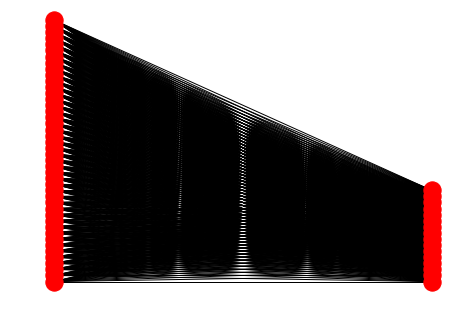

In [26]:
df_pruebas = matching.copy()     

G = create_graph(df_pruebas)
students_list = df_pruebas.index
companies_list = df_pruebas.columns

plot_bipartite_graph(G, students_list, companies_list)

node1, node2, w = get_best_match(G, 'Company ALL MID', [])
node1, node2, w

In [27]:

RONDAS = 15
# print(RONDAS)

print(len(students_list), students_list)

# student_queue = list(students_list) * RONDAS # vamos a recorrer la lista para ir emparejando

lista = list(students_list)
shuffle(lista)
print(lista)
student_queue = lista * RONDAS # vamos a recorrer la lista para ir emparejando
# print(student_queue)

44 Index(['Cristina Alonso Amiñoso', 'Marleny Francisco', 'Carmen Bustillos',
       'Karla Imbert Lamiquiz', 'Carlota Sánchez-Robles Herrero',
       'Maruxa Moreira Pérez', 'Barbara Lopez Mauriello',
       'Víctor Andrés Hernández', 'Luis Camacho Cabo', 'Marta Aboy Otero',
       'Sara Salguero', 'Luis Pelayo González', 'Adrian Muñoz Lobato',
       'Alberto Toca Muñoz', 'Nico Fernández Díaz-Pavón ', 'Magda Kupidlowska',
       'Ángel María Pulido Samper', 'ELENA CORBACHO NAVARRO',
       'Carolina Timhagen', 'Circe Serrano Gutiérrez', 'Satory Asensio Gómez',
       'Francisco García Hurtado', 'Joxan Bueno Fernández', 'Ana Fraile',
       'Jose Moreno Fernández', 'Jose Joaquin Martinez Abenza',
       'Pablo Arribas García', 'Carlota Fernández de Villavicencio Guerra',
       'Irene Fabelo Santana', 'Gurutz Gorrotxategi', 'Ignacio Romaní Vidal',
       'Marta Hierro', 'Galo Franganillo Arrese', 'Leticia serra',
       'Santi Beneitez', 'Bibiana Mora Gómez', 'Silvia Ambrós Muro',
   

In [28]:
rondas = []

for r in range(RONDAS): 
    aux = []
    used = []
    while len(used) < 2 * len(companies): # ahora used tiene el doble de tamaño. Hay que modificarlo
        student = student_queue.pop(0)
        # print(student)
        node1, node2, w = get_best_match(G, student, used) # creo que se queda sin opciones
        
        # aux.append((node1, node2, w))
        G.remove_edge(node1, node2)
        used.extend([node1, node2])
        
    
        # el nodo1 es la compañía (nodo1 no es estudiante)
        if node1 != student: 
            # used.append(node1)
            aux.append((node1, node2, w))
        # nodo2 es la compañía
        else: 
            # used.append(node2)
            aux.append((node2, node1, w))
        # print(used)
    rondas.append(aux)
        
rondas

[[('Sopra Steria', 'Santi Beneitez', 0.2968435085621167),
  ('Bravent ', 'Satory Asensio Gómez', 0.40252441541901074),
  ('UXSmobile', 'Magda Kupidlowska', 0.585786437626905),
  ('Garaje de Ideas', 'Joyfer Iborra', 0.457156606594614),
  ('Crepes and Texas (Making Science)', 'Leticia serra', 0.5612503886471016),
  ('Making Science', 'Marta Hierro', 0.38875258098754006),
  ('vt-lab', 'Cristina Alonso Amiñoso', 0.6246387977050463),
  ('Habitant', 'Pablo Arribas García', 0.5186827646039737),
  ('Sentisis', 'Jose Moreno Fernández', 1.0),
  ('EPSNWORKFORCE', 'Karla Imbert Lamiquiz', 0.3025976137844635),
  ('Barrabes', 'Víctor Andrés Hernández', 0.6666666666666666),
  ('Chiara', 'ELENA CORBACHO NAVARRO', 0.4861409638928438),
  ('Syntonize', 'Marta Aboy Otero', 0.4924225024706421),
  ('F. Iniciativas', 'Sara Salguero', 0.2968435085621167),
  ('Fontown', 'Nico Fernández Díaz-Pavón ', 0.40066043052894107),
  ('Minsait', 'Galo Franganillo Arrese', 0.2333823841809365)],
 [('Sopra Steria', 'Luis Pe

In [29]:
def check_rondas(rondas): 
    res = []
    for ronda in rondas: 
        companies = [company for company, student, w in ronda]
        students = [student for company, student, w in ronda]
        res.append(len(set(companies)) == len(set(students)) )
    return all(e for e in res)
            
check_rondas(rondas)            

True

In [30]:
def rondas2string(rondas):
    res = ''
    for i, ronda in enumerate(rondas): 
        res += '\n\nRonda {}'.format(i)
        for c, s, w in ronda: 
            res += '\nCompany: {} -> Student: {} -> Matching: {}'.format(c, s, w)
        
    return res
        
        
text = rondas2string(rondas)

with open("Rondas.txt", "w") as f:
    f.write(text)

In [31]:
# beautifultable

table = BeautifulTable()
table.column_headers = ["ronda", "company", "student", "match"]
for i, ronda in enumerate(rondas): 
    for row in ronda: 
        table.append_row([i, row[0], row[1], row[2]])
        
# print(table)

with open("Rondas_table.txt", "w") as f:
    f.write(str(table))

In [32]:
# agrupadas por compañía: 

table = BeautifulTable()
table.column_headers = ["company", "ronda", "student", "match"]

for company in companies_list: 
    for i, ronda in enumerate(rondas): 
        for row in ronda: 
            if row[0] == company: 
                table.append_row([row[0], i, row[1], row[2]])
        
# print(table)

with open("Rondas_table_by_company.txt", "w") as f:
    f.write(str(table))

In [33]:
companies_list

Index(['Sopra Steria', 'vt-lab', 'Barrabes', 'Sentisis', 'Habitant', 'Minsait',
       'Syntonize', 'UXSmobile', 'Bravent ', 'Making Science', 'Fontown',
       'Crepes and Texas (Making Science)', 'Garaje de Ideas', 'Chiara',
       'EPSNWORKFORCE', 'F. Iniciativas'],
      dtype='object', name='name')

In [34]:

table = BeautifulTable()
table.column_headers = ["student", "company", "ronda", "match"]

for student in students_list: 
    for i, ronda in enumerate(rondas): 
        for row in ronda: 
            if row[1] == student: 
                table.append_row([row[1], row[0], i, row[2]])
'''

'''    
with open("Rondas_table_by_student.txt", "w") as f:
    f.write(str(table))

In [35]:
student_rounds = {}

for student in students_list: 
    total = 0
    for ronda in rondas: 
        for row in ronda: 
            if row[1] == student: 
                total += 1
    student_rounds[student] = total

student_rounds

{'Cristina Alonso Amiñoso': 6,
 'Marleny Francisco': 5,
 'Carmen Bustillos': 5,
 'Karla Imbert Lamiquiz': 6,
 'Carlota Sánchez-Robles Herrero': 5,
 'Maruxa Moreira Pérez': 5,
 'Barbara Lopez Mauriello': 5,
 'Víctor Andrés Hernández': 6,
 'Luis Camacho Cabo': 5,
 'Marta Aboy Otero': 6,
 'Sara Salguero': 6,
 'Luis Pelayo González': 6,
 'Adrian Muñoz Lobato': 5,
 'Alberto Toca Muñoz': 5,
 'Nico Fernández Díaz-Pavón ': 6,
 'Magda Kupidlowska': 6,
 'Ángel María Pulido Samper': 5,
 'ELENA CORBACHO NAVARRO': 6,
 'Carolina Timhagen': 6,
 'Circe Serrano Gutiérrez': 5,
 'Satory Asensio Gómez': 6,
 'Francisco García Hurtado': 5,
 'Joxan Bueno Fernández': 5,
 'Ana Fraile': 6,
 'Jose Moreno Fernández': 6,
 'Jose Joaquin Martinez Abenza': 5,
 'Pablo Arribas García': 6,
 'Carlota Fernández de Villavicencio Guerra': 5,
 'Irene Fabelo Santana': 5,
 'Gurutz Gorrotxategi': 6,
 'Ignacio Romaní Vidal': 6,
 'Marta Hierro': 6,
 'Galo Franganillo Arrese': 6,
 'Leticia serra': 6,
 'Santi Beneitez': 6,
 'Bibian